In [2]:
import wandb
wandb.init(project='ChannelCharting')

W&B Run: https://app.wandb.ai/evs/ChannelCharting/runs/n2i7aahn

In [46]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import data_preparation

In [4]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")

In [5]:
real_mean = np.mean(np.real(data))
real_std = np.std(np.real(data))

In [6]:
imag_mean = np.mean(np.imag(data))
imag_std = np.std(np.imag(data))



In [7]:
#one sample example

In [8]:
one_sample = data[0:2,:,25:75]
one_sample_real = (np.real(one_sample) - real_mean)/real_std
one_sample_imag = (np.imag(one_sample) - imag_mean)/imag_std

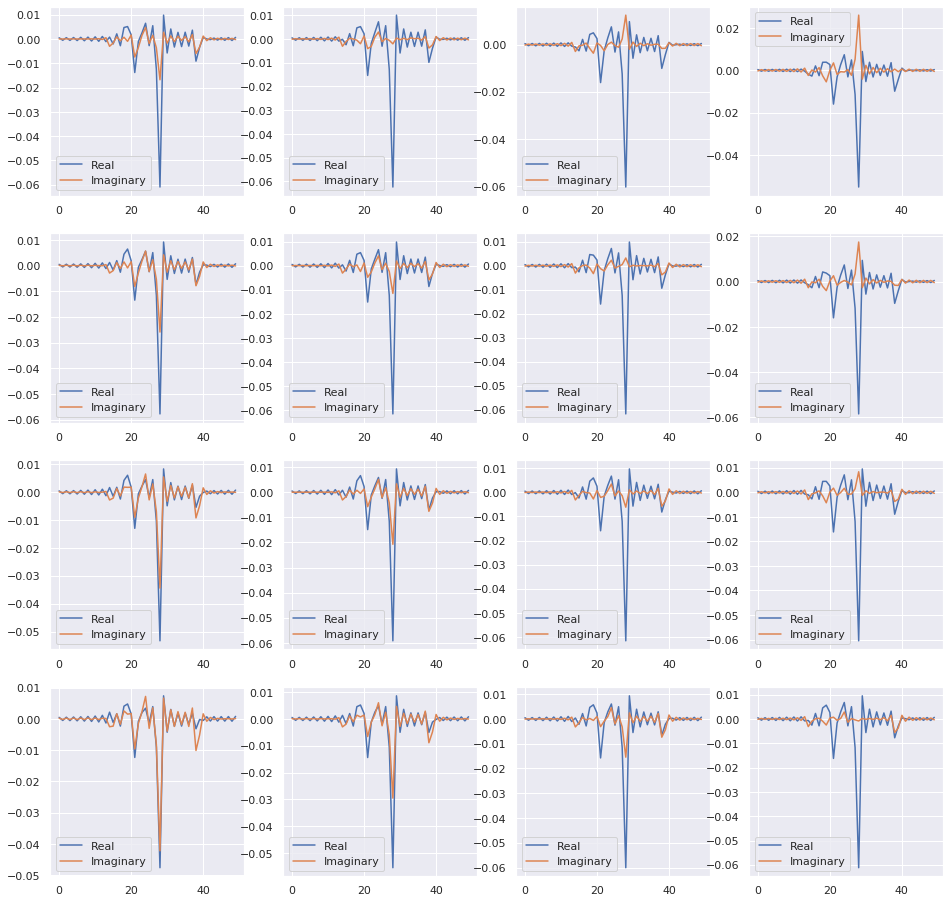

In [9]:
plt.figure(figsize=(16,16))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(one_sample_real[0, i-1, :], label='Real')
    plt.plot(one_sample_imag[0, i-1, :], label='Imaginary')
    plt.legend()

In [10]:
one_sample_full = np.concatenate([one_sample_real, one_sample_imag], axis=0)

In [11]:
one_sample_full.shape

(4, 16, 50)

We observe that a lot of information is contained on the imaginary part of the impulse. So the 16 antennas, we are gong to have 32 'Channels' for our dataset. 
So we will have a training batch of shape [batch_size, 32 , 100].

# Siamese Neural Network

In [12]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Setting up the Custom Dataset

In [13]:
idces = np.random.randint(0, data.shape[0], int(0.1*data.shape[0]))
data_undersampled = data[idces]

In [14]:
data_undersampled.shape

(2392, 16, 100)

In [15]:
data_undersampled.shape
# train test split
train, test= train_test_split(data_undersampled)

In [16]:
train_dataset = data_preparation.SiameseDataset(train)
scaler = train_dataset.scaler_real, train_dataset.scaler_imag
test_dataset = data_preparation.SiameseDataset(test, scaler)

In [41]:
scaler[1].transform(np.real(test)).std()

0.6823229686328953

In [42]:
train_dataset[0][0].std()

tensor(0.0004)

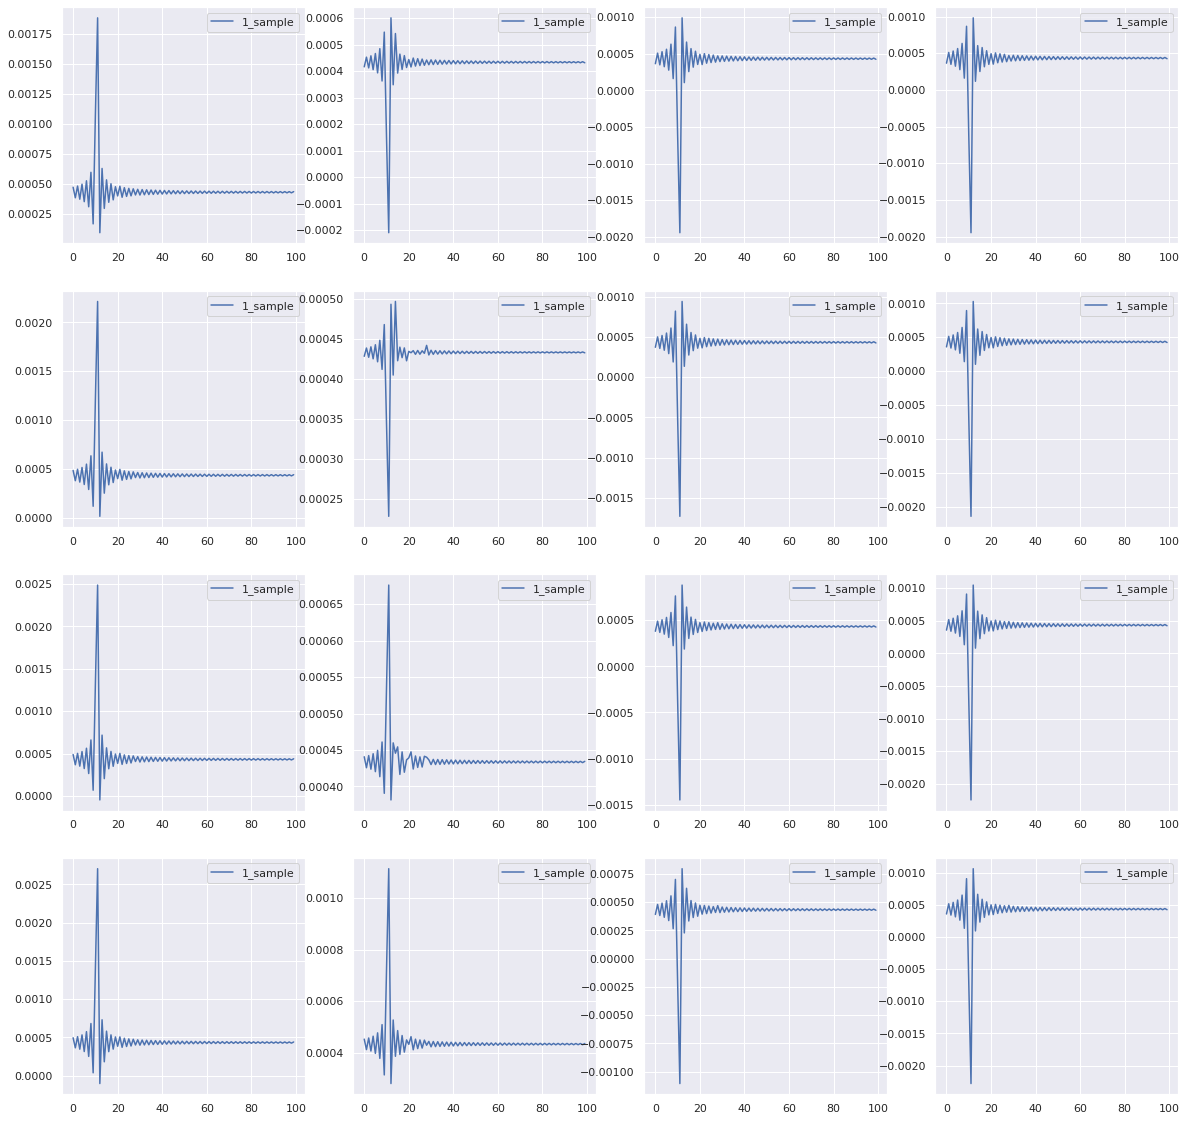

In [47]:
plt.figure(figsize=(20,20))
for i  in range(1, 17):
    plt.subplot(4,4,i)
    plt.plot(train_dataset[0][0][i-1, :], label='1_sample')
    #plt.plot(train_dataset[0][1][i-1, :], label='2_sample')
    plt.legend()

In [20]:
train_dataset.nb_channels()

32

In [21]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=16)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=8)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=4)
        
        f = data_preparation.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=16),
                                                       kernel_size=8), 
                                                         kernel_size=4)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        
        out = self.lin4(x)
        
        return out
        
    

In [22]:
model = SimpleNN()
wandb.watch(model)


In [23]:
def loss_function(x1, x2, y1, y2):
    x_difference = torch.mean(torch.abs(x1 - x2), dim=[1,2])
    y_difference = torch.mean(torch.abs(y1 - y2), dim=[1])
    return torch.sum(torch.pow(x_difference - y_difference, 2))

In [24]:
#x1, x2 = train_dataset[0:10][0], train_dataset[0:10][1]
#y1, y2 = model(x1), model(x2)

## Training

In [25]:
a = len(test_dataset)/len(train_dataset)
batch_size = 64

In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
criterion = loss_function
optimizer = optim.Adam(model.parameters())


In [50]:
wandb.log({"Batch_size": batch_size})
for e in range(20):
    # train
    loss = 0
    
    for x1, x2 in train_loader:
        
        optimizer.zero_grad()
        y1, y2 = model(x1), model(x2)
        
        batch_loss = criterion(x1, x2, y1 ,y2)
        
        batch_loss.backward()
        optimizer.step()
    
        loss+=batch_loss
    
    #validation
    model.eval()
    val_loss = 0
    for x1, x2 in test_loader:
        y1, y2 = model(x1), model(x2)
        val_loss += criterion(x1, x2, y1 ,y2)
    
    wandb.log({
        "Training Loss": loss,
        "Validation Loss": val_loss,
    })
    print(f"Epoch {e+1}, Training Loss: {a*loss}, Validation Loss: {val_loss}")

Epoch 1, Training Loss: 1.2082916498184204, Validation Loss: 1.1123988628387451
Epoch 2, Training Loss: 0.4660952091217041, Validation Loss: 1.6398531198501587
Epoch 3, Training Loss: 0.61660236120224, Validation Loss: 1.538517713546753
Epoch 4, Training Loss: 0.21316242218017578, Validation Loss: 5.797628402709961
Epoch 5, Training Loss: 1.2988672256469727, Validation Loss: 1.2184021472930908
Epoch 6, Training Loss: 0.3162422776222229, Validation Loss: 2.6819186210632324
Epoch 7, Training Loss: 0.3186270296573639, Validation Loss: 1.1934679746627808
Epoch 8, Training Loss: 0.3961380124092102, Validation Loss: 1.2817834615707397
Epoch 9, Training Loss: 0.5058982372283936, Validation Loss: 3.0347774028778076
Epoch 10, Training Loss: 0.45657604932785034, Validation Loss: 1.0424344539642334
Epoch 11, Training Loss: 1.5683817863464355, Validation Loss: 2.9284093379974365
Epoch 12, Training Loss: 0.5260288715362549, Validation Loss: 1.2914272546768188
Epoch 13, Training Loss: 0.321385800838

## Evaluate results

In [35]:
example_1, example_2 = test_dataset[0:1]
example_1.shape, example_2.shape

(torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [36]:
example_1_mapping, example_2_mapping = model(example_1), model(example_2)

In [38]:
example_1_mapping, example_2_mapping

(tensor([[-0.4429,  0.0804, -0.0458]], grad_fn=<AddmmBackward>),
 tensor([[-0.4429,  0.0804, -0.0458]], grad_fn=<AddmmBackward>))